In [0]:
import numpy as np
import random
import pandas as pd 
import matplotlib.pyplot as plt
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def read_file(path):
  ''' This function reads the csv file containg all the details 
  of stock prices.

  Argument: path (String) to the csv file
  Return: A dataframe conataing only the closing price of the stock'''

  stock_data = pd.read_csv(path)
  return stock_data[['Close']]

In [0]:
def load_data(stock, look_back):
  '''This function accepts closing prices of the stock and sequence length and 
  returns all possible sequneces of length look back

  Arguments: 
  stock: closing prices of a particular stock
  look_back: sequence length

  Return:
  X_train: training feature dataset of size n_seq*seq_length*features
  y_train: true stock prices for training of size n_seq*1
  X_test: test feature dataset of size n_seq*seq_length*features
  y_test: true stock prices for training of size n_seq*1'''

  data_raw = np.array(stock) # convert to numpy array
  data = []
  
  # create all possible sequences of length seq_len
  for index in range(len(data_raw) - look_back): 
      data.append(data_raw[index: index + look_back])
  
  data = np.array(data);
  test_set_size = int(np.round(0.2*data.shape[0]));
  train_set_size = data.shape[0] - (test_set_size);

  
  x_train = data[:train_set_size,:-1]
  y_train = data[:train_set_size,-1]
  
  x_test = data[train_set_size:,:-1]
  y_test = data[train_set_size:,-1]
  
  return x_train, y_train, x_test, y_test


In [0]:
def data_preprocessing(stock_close):
  ''' Fills all the missing closing prices by propagate last valid observation 
  forward to next valid. Then the values are scaled to the range (-1,1)
  
  Arguments:
  stock_close: Dataframe containg only the 'Close' column

  Return:
  stock_close['Close']: 2d array scaled closing prices of the stock
  scaler: Min Max scaler object
  '''

  stock_close=stock_close.fillna(method='ffill')

  scaler = MinMaxScaler(feature_range=(-1, 1))
  stock_close['Close'] = scaler.fit_transform(stock_close['Close'].values.reshape(-1,1))
  return stock_close['Close'], scaler 

In [0]:
# LSTM Model

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.fc(out[:, -1, :]) 
        return out

In [0]:
# Instatiating the LSTM model
def instantiate_model(input_dim=1, hidden_dim = 32, num_layers = 2, output_dim = 1):
  '''This function instantiates the LSTM model.

  Arguments:
  input_dim: number of features of input data
  hidden_dim: number of features of hidden states
  num_layers: number of layers in a multi dimensional LSTM
  output_dim: number of features of the output

  Returns:
  model: LSTM model'''

  model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
  return(model)

In [0]:
def train(model,x_train, y_train, epochs=150, look_back = 20):

  criterion = torch.nn.MSELoss(reduction='mean')
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  
  loss_history = np.zeros(epochs) #to store the loss every epoch
  seq_dim =look_back-1   

  epochs = epochs

  for epoch in range(epochs):
    # Initialise hidden state
    
    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()
    # Forward pass
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)

    print("Epoch: {} | MSE: {} ".format(epoch, loss.item()))
    loss_history[epoch] = loss.item()

    # Backward pass
    loss.backward()
    optimizer.step()

  return(loss_history, y_train_pred)

In [0]:
def test_model(model, scaler, x_test, y_train, y_train_pred, y_test):

  y_test_pred = model(x_test)

  # inverse Transform
  y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
  y_train = scaler.inverse_transform(y_train.detach().numpy())
  y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
  y_test = scaler.inverse_transform(y_test.detach().numpy())

  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))

  return(y_train_pred, y_test_pred)

In [0]:
def plot_training_results(y_train_pred, y_train, hist, stock_name):

  plt.plot(y_train_pred.detach().numpy(), label="Predicted price")
  plt.plot(y_train.detach().numpy(), label="Actual Price")
  plt.legend()
  plt.show()


  # Plotting the loss curve
  plt.plot(hist, label="Training loss")
  plt.legend()
  plt.title(stock_name)
  plt.show()

  

In [0]:
def plot_test_results(y_train_pred, y_test_pred,scaler,stock_name,stock_close):  
  
  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(stock_close).reshape(-1,1)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(y_train_pred)+look_back, :] = y_train_pred

  # shift test predictions for plotting
  testPredictPlot = np.empty_like(stock_close).reshape(-1,1)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(y_train_pred)+look_back-1:len(stock_close)-1, :] = y_test_pred

  # plot baseline and predictions
  plt.figure(figsize=(15,8))
  plt.plot(scaler.inverse_transform(np.array(stock_close).reshape(-1,1)))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.title(stock_name)
  plt.show()

  

## Google

In [0]:
stock_close = read_file('./drive/My Drive/Datasets/Stock Price Data/GOOGL.csv')
stock_close, scaler = data_preprocessing(stock_close)

In [29]:
stock_close.shape[0]

5434

In [30]:
look_back = 20 # choose sequence length
x_train, y_train, x_test, y_test = load_data(stock_close, look_back)

x_train = x_train.reshape((x_train.shape[0],-1,1))
y_train = y_train.reshape((y_train.shape[0],1))
x_test = x_test.reshape((x_test.shape[0],-1,1))
y_test = y_test.reshape((y_test.shape[0],1))
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (4331, 19, 1)
y_train.shape =  (4331, 1)
x_test.shape =  (1083, 19, 1)
y_test.shape =  (1083, 1)


In [31]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

y_train.size(),x_train.size()

(torch.Size([4331, 1]), torch.Size([4331, 19, 1]))

In [32]:
model = instantiate_model()
print(model)


LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [33]:
loss_history, y_train_pred = train(model, x_train, y_train)

Epoch: 0 | MSE: 0.33511340618133545 
Epoch: 1 | MSE: 0.19620558619499207 
Epoch: 2 | MSE: 0.08969134837388992 
Epoch: 3 | MSE: 0.14766384661197662 
Epoch: 4 | MSE: 0.08596136420965195 
Epoch: 5 | MSE: 0.06976217776536942 
Epoch: 6 | MSE: 0.08028632402420044 
Epoch: 7 | MSE: 0.08835286647081375 
Epoch: 8 | MSE: 0.08833973109722137 
Epoch: 9 | MSE: 0.08193772286176682 
Epoch: 10 | MSE: 0.0723377913236618 
Epoch: 11 | MSE: 0.06309527158737183 
Epoch: 12 | MSE: 0.057839635759592056 
Epoch: 13 | MSE: 0.05842313915491104 
Epoch: 14 | MSE: 0.06062837317585945 
Epoch: 15 | MSE: 0.05617903172969818 
Epoch: 16 | MSE: 0.04418338090181351 
Epoch: 17 | MSE: 0.03231457620859146 
Epoch: 18 | MSE: 0.026263315230607986 
Epoch: 19 | MSE: 0.020709358155727386 
Epoch: 20 | MSE: 0.007994120009243488 
Epoch: 21 | MSE: 0.015317978337407112 
Epoch: 22 | MSE: 0.011736410669982433 
Epoch: 23 | MSE: 0.009787180460989475 
Epoch: 24 | MSE: 0.01499016210436821 
Epoch: 25 | MSE: 0.008417552337050438 
Epoch: 26 | MSE

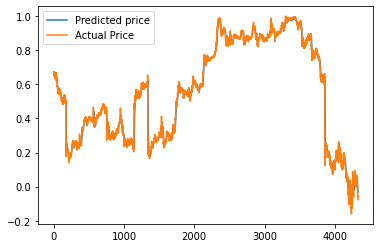

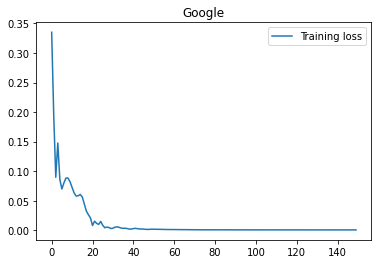

In [40]:
plot_training_results(y_train_pred, y_train, loss_history, 'Google')

In [41]:
y_train_pred, y_test_pred = test_model(model, scaler, x_test, y_train, y_train_pred, y_test)

Train Score: 3.12 RMSE
Test Score: 19.21 RMSE


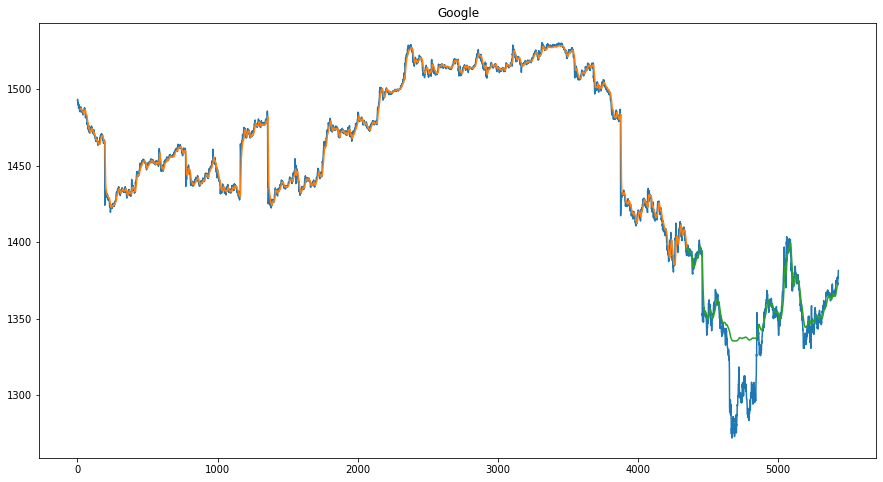

In [42]:
plot_test_results(y_train_pred, y_test_pred, scaler,'Google', stock_close)

## Apple

In [0]:
stock_close = read_file('./drive/My Drive/Datasets/Stock Price Data/AAPL.csv')
stock_close, scaler = data_preprocessing(stock_close)

In [44]:
stock_close.shape[0]

5434

In [45]:
look_back = 20 # choose sequence length
x_train, y_train, x_test, y_test = load_data(stock_close, look_back)

x_train = x_train.reshape((x_train.shape[0],-1,1))
y_train = y_train.reshape((y_train.shape[0],1))
x_test = x_test.reshape((x_test.shape[0],-1,1))
y_test = y_test.reshape((y_test.shape[0],1))
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (4331, 19, 1)
y_train.shape =  (4331, 1)
x_test.shape =  (1083, 19, 1)
y_test.shape =  (1083, 1)


In [46]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

y_train.size(),x_train.size()

(torch.Size([4331, 1]), torch.Size([4331, 19, 1]))

In [47]:
model = instantiate_model()
print(model)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [48]:
loss_history, y_train_pred = train(model, x_train, y_train)

Epoch: 0 | MSE: 0.7609327435493469 
Epoch: 1 | MSE: 0.5006973147392273 
Epoch: 2 | MSE: 0.23983408510684967 
Epoch: 3 | MSE: 0.04503177851438522 
Epoch: 4 | MSE: 0.34389394521713257 
Epoch: 5 | MSE: 0.13561376929283142 
Epoch: 6 | MSE: 0.04537816718220711 
Epoch: 7 | MSE: 0.06383223086595535 
Epoch: 8 | MSE: 0.096837617456913 
Epoch: 9 | MSE: 0.11310090869665146 
Epoch: 10 | MSE: 0.1121857538819313 
Epoch: 11 | MSE: 0.10033898055553436 
Epoch: 12 | MSE: 0.08383449167013168 
Epoch: 13 | MSE: 0.06775869429111481 
Epoch: 14 | MSE: 0.05575552582740784 
Epoch: 15 | MSE: 0.049786005169153214 
Epoch: 16 | MSE: 0.049909863620996475 
Epoch: 17 | MSE: 0.05433834716677666 
Epoch: 18 | MSE: 0.0600082129240036 
Epoch: 19 | MSE: 0.06380713731050491 
Epoch: 20 | MSE: 0.06408779323101044 
Epoch: 21 | MSE: 0.06119098514318466 
Epoch: 22 | MSE: 0.056668009608983994 
Epoch: 23 | MSE: 0.052202269434928894 
Epoch: 24 | MSE: 0.04891824722290039 
Epoch: 25 | MSE: 0.047205083072185516 
Epoch: 26 | MSE: 0.0468

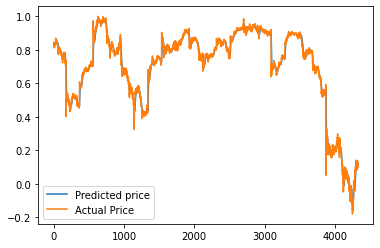

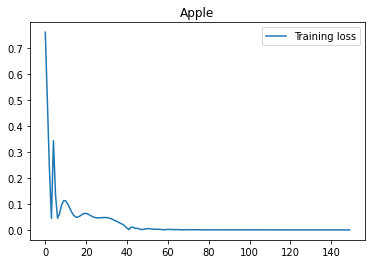

In [49]:
plot_training_results(y_train_pred, y_train, loss_history, 'Apple')

In [50]:
y_train_pred, y_test_pred = test_model(model, scaler, x_test, y_train, y_train_pred, y_test)

Train Score: 0.87 RMSE
Test Score: 6.39 RMSE


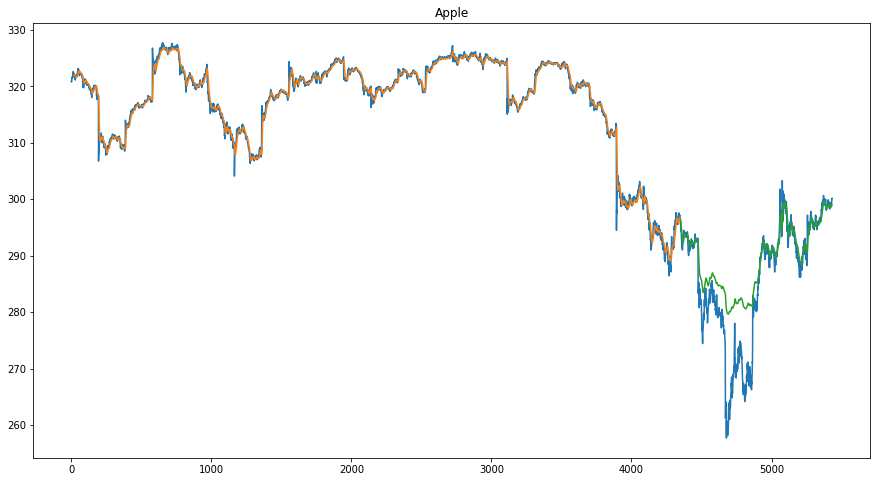

In [51]:
plot_test_results(y_train_pred, y_test_pred, scaler,'Apple',stock_close)

## Amazon

In [0]:
stock_close = read_file('./drive/My Drive/Datasets/Stock Price Data/AMZN.csv')
stock_close, scaler = data_preprocessing(stock_close)

In [53]:
stock_close.shape[0]

5434

In [54]:
look_back = 20 # choose sequence length
x_train, y_train, x_test, y_test = load_data(stock_close, look_back)

x_train = x_train.reshape((x_train.shape[0],-1,1))
y_train = y_train.reshape((y_train.shape[0],1))
x_test = x_test.reshape((x_test.shape[0],-1,1))
y_test = y_test.reshape((y_test.shape[0],1))
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (4331, 19, 1)
y_train.shape =  (4331, 1)
x_test.shape =  (1083, 19, 1)
y_test.shape =  (1083, 1)


In [55]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

y_train.size(),x_train.size()

(torch.Size([4331, 1]), torch.Size([4331, 19, 1]))

In [56]:
model = instantiate_model()
print(model)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [57]:
loss_history, y_train_pred = train(model, x_train, y_train)

Epoch: 0 | MSE: 0.5012372136116028 
Epoch: 1 | MSE: 0.4127194285392761 
Epoch: 2 | MSE: 0.32539504766464233 
Epoch: 3 | MSE: 0.2878366708755493 
Epoch: 4 | MSE: 0.23156343400478363 
Epoch: 5 | MSE: 0.15160101652145386 
Epoch: 6 | MSE: 0.09984510391950607 
Epoch: 7 | MSE: 0.0754467248916626 
Epoch: 8 | MSE: 0.07179218530654907 
Epoch: 9 | MSE: 0.08030734211206436 
Epoch: 10 | MSE: 0.0726972296833992 
Epoch: 11 | MSE: 0.05766773223876953 
Epoch: 12 | MSE: 0.03309483826160431 
Epoch: 13 | MSE: 0.014377149753272533 
Epoch: 14 | MSE: 0.007350787054747343 
Epoch: 15 | MSE: 0.012290557846426964 
Epoch: 16 | MSE: 0.019075574353337288 
Epoch: 17 | MSE: 0.01921462081372738 
Epoch: 18 | MSE: 0.017032600939273834 
Epoch: 19 | MSE: 0.01659785397350788 
Epoch: 20 | MSE: 0.015009789727628231 
Epoch: 21 | MSE: 0.010850478895008564 
Epoch: 22 | MSE: 0.006435287185013294 
Epoch: 23 | MSE: 0.0035150963813066483 
Epoch: 24 | MSE: 0.002002718625590205 
Epoch: 25 | MSE: 0.002430228516459465 
Epoch: 26 | MSE

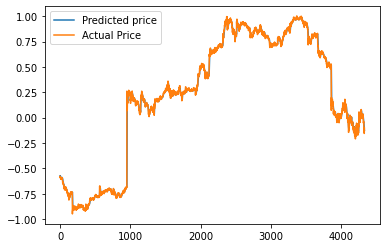

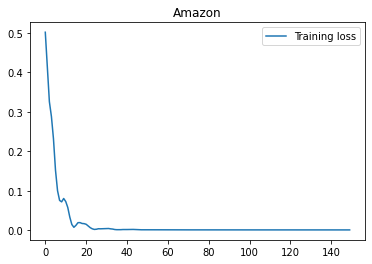

In [58]:
plot_training_results(y_train_pred, y_train, loss_history, 'Amazon')

In [59]:
y_train_pred, y_test_pred = test_model(model, scaler, x_test, y_train, y_train_pred, y_test)

Train Score: 5.01 RMSE
Test Score: 7.12 RMSE


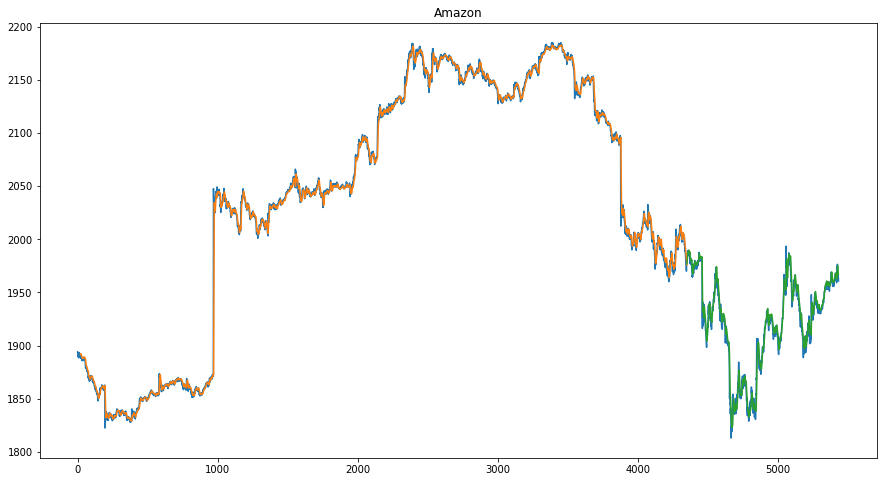

In [60]:
plot_test_results(y_train_pred, y_test_pred, scaler,'Amazon',stock_close)

## Microsoft

In [0]:
stock_close = read_file('./drive/My Drive/Datasets/Stock Price Data/MSFT.csv')
stock_close, scaler = data_preprocessing(stock_close)

In [62]:
stock_close.shape[0]

5434

In [63]:
look_back = 20 # choose sequence length
x_train, y_train, x_test, y_test = load_data(stock_close, look_back)

x_train = x_train.reshape((x_train.shape[0],-1,1))
y_train = y_train.reshape((y_train.shape[0],1))
x_test = x_test.reshape((x_test.shape[0],-1,1))
y_test = y_test.reshape((y_test.shape[0],1))
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (4331, 19, 1)
y_train.shape =  (4331, 1)
x_test.shape =  (1083, 19, 1)
y_test.shape =  (1083, 1)


In [64]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

y_train.size(),x_train.size()

(torch.Size([4331, 1]), torch.Size([4331, 19, 1]))

In [65]:
model = instantiate_model()
print(model)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [66]:
loss_history, y_train_pred = train(model, x_train, y_train)

Epoch: 0 | MSE: 0.2596334218978882 
Epoch: 1 | MSE: 0.20028360188007355 
Epoch: 2 | MSE: 0.16065919399261475 
Epoch: 3 | MSE: 0.1483275145292282 
Epoch: 4 | MSE: 0.10658134520053864 
Epoch: 5 | MSE: 0.05402965098619461 
Epoch: 6 | MSE: 0.01968214474618435 
Epoch: 7 | MSE: 0.03355440869927406 
Epoch: 8 | MSE: 0.08759883046150208 
Epoch: 9 | MSE: 0.06723601371049881 
Epoch: 10 | MSE: 0.02173527516424656 
Epoch: 11 | MSE: 0.02394540049135685 
Epoch: 12 | MSE: 0.0166806410998106 
Epoch: 13 | MSE: 0.006243053823709488 
Epoch: 14 | MSE: 0.010478929616510868 
Epoch: 15 | MSE: 0.01609605923295021 
Epoch: 16 | MSE: 0.016838736832141876 
Epoch: 17 | MSE: 0.013138244859874249 
Epoch: 18 | MSE: 0.007960011251270771 
Epoch: 19 | MSE: 0.005044772755354643 
Epoch: 20 | MSE: 0.006924336310476065 
Epoch: 21 | MSE: 0.011356886476278305 
Epoch: 22 | MSE: 0.012207993306219578 
Epoch: 23 | MSE: 0.008728573098778725 
Epoch: 24 | MSE: 0.005378882400691509 
Epoch: 25 | MSE: 0.004681653808802366 
Epoch: 26 | M

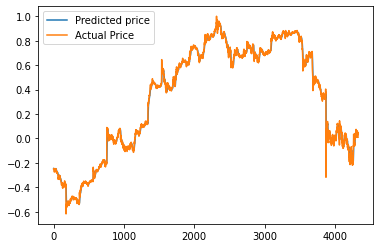

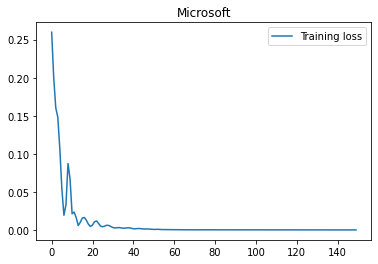

In [67]:
plot_training_results(y_train_pred, y_train, loss_history, 'Microsoft')

In [68]:
y_train_pred, y_test_pred = test_model(model, scaler, x_test, y_train, y_train_pred, y_test)

Train Score: 0.42 RMSE
Test Score: 0.89 RMSE


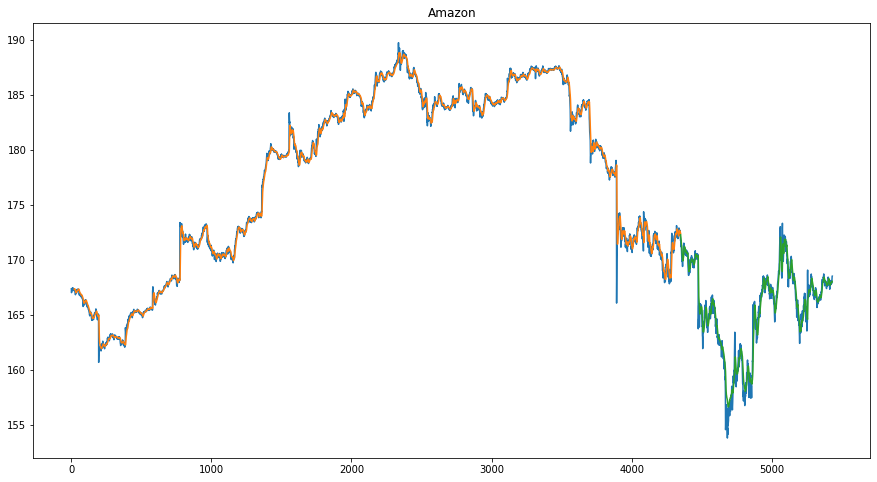

In [69]:
plot_test_results(y_train_pred, y_test_pred, scaler,'Amazon',stock_close)

## NetFlix

In [0]:
stock_close = read_file('./drive/My Drive/Datasets/Stock Price Data/NFLX.csv')
stock_close, scaler = data_preprocessing(stock_close)

In [71]:
stock_close.shape[0]

5434

In [72]:
look_back = 20 # choose sequence length
x_train, y_train, x_test, y_test = load_data(stock_close, look_back)

x_train = x_train.reshape((x_train.shape[0],-1,1))
y_train = y_train.reshape((y_train.shape[0],1))
x_test = x_test.reshape((x_test.shape[0],-1,1))
y_test = y_test.reshape((y_test.shape[0],1))
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (4331, 19, 1)
y_train.shape =  (4331, 1)
x_test.shape =  (1083, 19, 1)
y_test.shape =  (1083, 1)


In [73]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

y_train.size(),x_train.size()

(torch.Size([4331, 1]), torch.Size([4331, 19, 1]))

In [74]:
model = instantiate_model()
print(model)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [75]:
loss_history, y_train_pred = train(model, x_train, y_train)

Epoch: 0 | MSE: 0.3194560110569 
Epoch: 1 | MSE: 0.2914392352104187 
Epoch: 2 | MSE: 0.26058194041252136 
Epoch: 3 | MSE: 0.2041494995355606 
Epoch: 4 | MSE: 0.10462825000286102 
Epoch: 5 | MSE: 0.056439369916915894 
Epoch: 6 | MSE: 0.07043333351612091 
Epoch: 7 | MSE: 0.050504427403211594 
Epoch: 8 | MSE: 0.01080323290079832 
Epoch: 9 | MSE: 0.01408088393509388 
Epoch: 10 | MSE: 0.023763036355376244 
Epoch: 11 | MSE: 0.025604702532291412 
Epoch: 12 | MSE: 0.02193359099328518 
Epoch: 13 | MSE: 0.014964248053729534 
Epoch: 14 | MSE: 0.009324903599917889 
Epoch: 15 | MSE: 0.010416491888463497 
Epoch: 16 | MSE: 0.015641605481505394 
Epoch: 17 | MSE: 0.01617458090186119 
Epoch: 18 | MSE: 0.011372577399015427 
Epoch: 19 | MSE: 0.006485693622380495 
Epoch: 20 | MSE: 0.004885663278400898 
Epoch: 21 | MSE: 0.00631454074755311 
Epoch: 22 | MSE: 0.008353951387107372 
Epoch: 23 | MSE: 0.008910772390663624 
Epoch: 24 | MSE: 0.00777797494083643 
Epoch: 25 | MSE: 0.00632499111816287 
Epoch: 26 | MSE

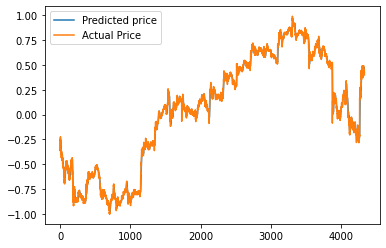

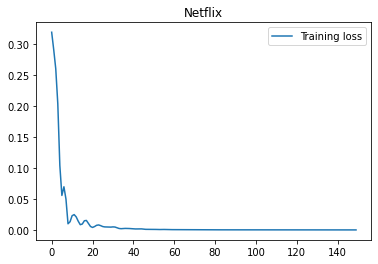

In [76]:
plot_training_results(y_train_pred, y_train, loss_history, 'Netflix')

In [77]:
y_train_pred, y_test_pred = test_model(model, scaler, x_test, y_train, y_train_pred, y_test)

Train Score: 0.81 RMSE
Test Score: 1.44 RMSE


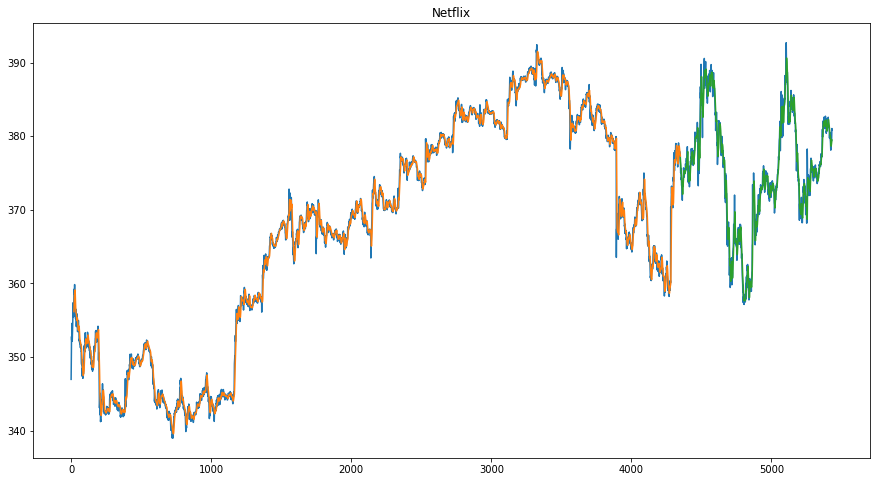

In [78]:
plot_test_results(y_train_pred, y_test_pred, scaler,'Netflix',stock_close)

## Nvidia

In [0]:
stock_close = read_file('./drive/My Drive/Datasets/Stock Price Data/NVDA.csv')
stock_close, scaler = data_preprocessing(stock_close)

In [81]:
stock_close.shape[0]

5434

In [82]:
look_back = 20 # choose sequence length
x_train, y_train, x_test, y_test = load_data(stock_close, look_back)

x_train = x_train.reshape((x_train.shape[0],-1,1))
y_train = y_train.reshape((y_train.shape[0],1))
x_test = x_test.reshape((x_test.shape[0],-1,1))
y_test = y_test.reshape((y_test.shape[0],1))
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (4331, 19, 1)
y_train.shape =  (4331, 1)
x_test.shape =  (1083, 19, 1)
y_test.shape =  (1083, 1)


In [83]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

y_train.size(),x_train.size()

(torch.Size([4331, 1]), torch.Size([4331, 19, 1]))

In [84]:
model = instantiate_model()
print(model)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [85]:
loss_history, y_train_pred = train(model, x_train, y_train)

Epoch: 0 | MSE: 0.4386179745197296 
Epoch: 1 | MSE: 0.35399430990219116 
Epoch: 2 | MSE: 0.2966324985027313 
Epoch: 3 | MSE: 0.27677077054977417 
Epoch: 4 | MSE: 0.25171753764152527 
Epoch: 5 | MSE: 0.20213183760643005 
Epoch: 6 | MSE: 0.15449917316436768 
Epoch: 7 | MSE: 0.09188852459192276 
Epoch: 8 | MSE: 0.061956003308296204 
Epoch: 9 | MSE: 0.03784643113613129 
Epoch: 10 | MSE: 0.06923357397317886 
Epoch: 11 | MSE: 0.05426955595612526 
Epoch: 12 | MSE: 0.04220307618379593 
Epoch: 13 | MSE: 0.018222736194729805 
Epoch: 14 | MSE: 0.011019021272659302 
Epoch: 15 | MSE: 0.013410129584372044 
Epoch: 16 | MSE: 0.013986737467348576 
Epoch: 17 | MSE: 0.011885509826242924 
Epoch: 18 | MSE: 0.010624079033732414 
Epoch: 19 | MSE: 0.013893493451178074 
Epoch: 20 | MSE: 0.01820909045636654 
Epoch: 21 | MSE: 0.01587628200650215 
Epoch: 22 | MSE: 0.011265291832387447 
Epoch: 23 | MSE: 0.009801628068089485 
Epoch: 24 | MSE: 0.00981528963893652 
Epoch: 25 | MSE: 0.008253049105405807 
Epoch: 26 | M

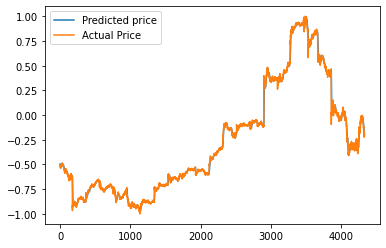

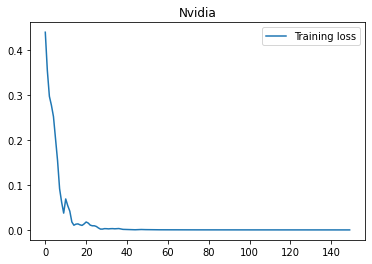

In [86]:
plot_training_results(y_train_pred, y_train, loss_history, 'Nvidia')

In [87]:
y_train_pred, y_test_pred = test_model(model, scaler, x_test, y_train, y_train_pred, y_test)

Train Score: 1.02 RMSE
Test Score: 1.45 RMSE


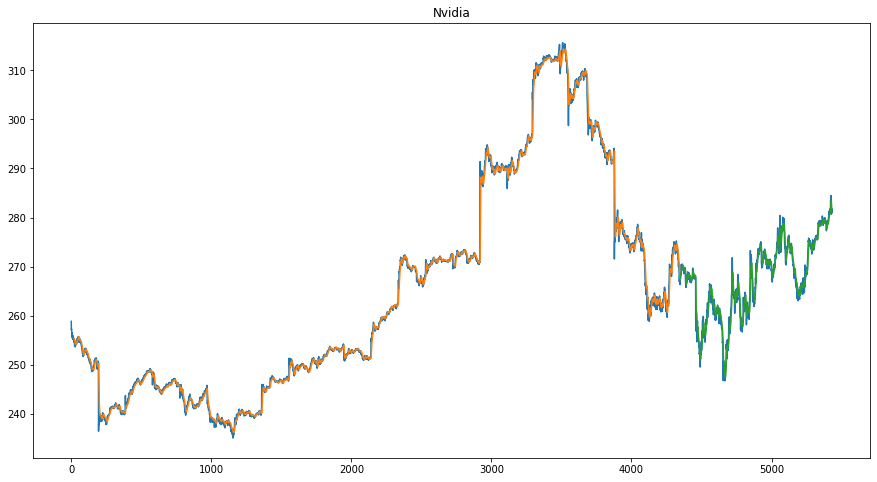

In [88]:
plot_test_results(y_train_pred, y_test_pred, scaler,'Nvidia',stock_close)